In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sklearn as sk
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras as K
import xgboost as xg

import numpy as np
from numpy import random as rand
rand.seed(2442)

/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1) Example de feature engineering

In [2]:
n_points = 1000000
angles = pd.Series(rand.uniform(0,2*np.pi,n_points),name="angle")
true_radius = pd.Series(rand.choice(range(0,10),n_points),name="true_radius")

circle_data = pd.DataFrame(zip(angles,true_radius),columns=["angle","true_radius"])
circle_data = circle_data.assign(radius=lambda x: rand.normal(x.true_radius, 0.4))

circle_data["target"] = circle_data["true_radius"].map(lambda x: np.rint(x)%2)
circle_data["x"] = circle_data["radius"] * np.cos(circle_data["angle"])
circle_data["y"] = circle_data["radius"] * np.sin(circle_data["angle"])
circle_data["z"] = rand.uniform(0,10,n_points)

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


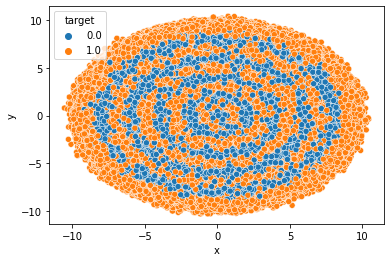

In [3]:
sns.scatterplot(x="x",y="y",data=circle_data,hue="target")
plt.show()

<AxesSubplot:xlabel='x', ylabel='reco_radius'>

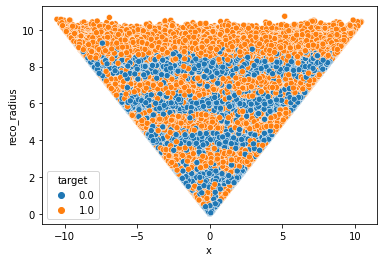

In [4]:
circle_data["reco_radius"] = np.sqrt(circle_data["x"]**2 + circle_data["y"]**2)
sns.scatterplot(data=circle_data,x="x",y="reco_radius",hue="target")

<AxesSubplot:xlabel='is_odd', ylabel='Count'>

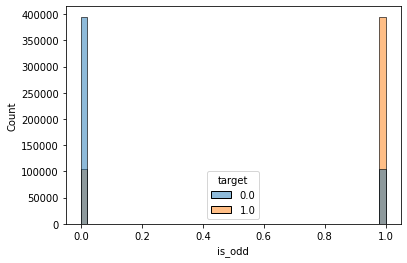

In [5]:
circle_data['is_odd'] = circle_data['reco_radius'].map(lambda x: np.rint(x)%2)
sns.histplot(data=circle_data,x="is_odd",hue="target")

In [6]:
metrics.accuracy_score(circle_data["target"],circle_data['is_odd'])

0.78894

# 2) Example over-fitting & underfitting

In [7]:
rand.seed(2442)

npoints=60
x = rand.normal(0,2,npoints)
y = 3*x+5*x**2-3*x**3+rand.normal(0,20,npoints)
y -= min(y)
y /= max(y)

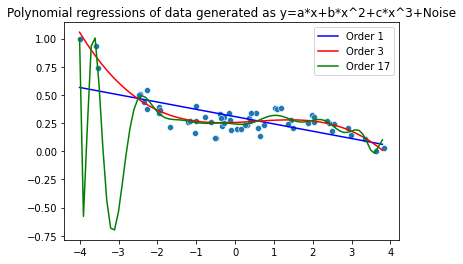

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def poly_reg(deg,x):
    poly_reg = PolynomialFeatures(degree=deg)
    X_poly = poly_reg.fit_transform(x.reshape(-1, 1))
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)
    return pol_reg,poly_reg

X_grid = np.arange(min(x), max(x), 0.1)
X_grid = X_grid.reshape(len(X_grid), 1) 

orders={
    1:'blue',
    3:'red',
    17:'green',
}

for id,val in orders.items():
    pol,poly = poly_reg(id,x)
    plt.plot(X_grid, pol.predict(poly.fit_transform(X_grid)), color=val,label=f"Order {id}")

sns.scatterplot(x=x,y=y)
plt.title("Polynomial regressions of data generated as y=a*x+b*x^2+c*x^3+Noise")
plt.show()

# 3) Example coefficient correlation

### 1 - Multivariate Gaussian

In [9]:
rand.seed(2442)

npoints=1000
# Moyennes :
m = np.array([-1,1,4])
# Matrice de correlation souhaitee
r = np.array(
    [
        [  1, 0.2, 0.5],
        [ 0.2,  1, 0.7],
        [ 0.5, 0.7, 1]
    ])
data_corr = pd.DataFrame(rand.multivariate_normal(m, r, size=npoints),columns=['x','y','z'])

Text(0.5, 1.0, 'Multi-variate gaussian model (2D proj)')

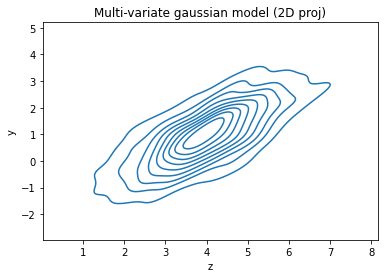

In [10]:
sns.kdeplot(x='z',y='y',data=data_corr)
plt.title("Multi-variate gaussian model (2D proj)")

Text(0.5, 1.0, 'Correlation plot for data generated according to multi-variate Gaussian')

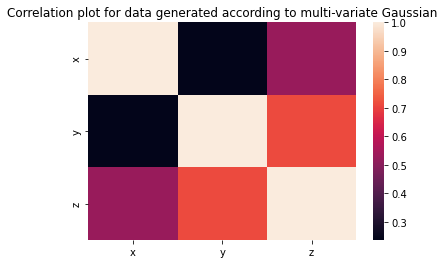

In [11]:
sns.heatmap(data_corr.corr())
plt.title("Correlation plot for data generated according to multi-variate Gaussian")

### 2 - Example where correlations doesn't show the relation & Mutual Information does

Let's take back the "circle" model we had before, and this time add an additional uniform dimension that's not linked to the target (z)

Text(0.5, 1.0, 'Correlation plot for data from the "circle" model')

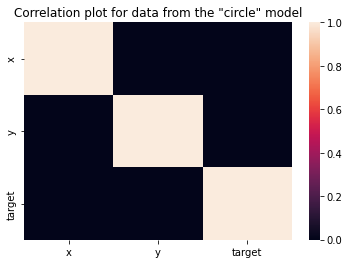

In [12]:
sns.heatmap(circle_data[["x","y","target"]].corr())
plt.title("Correlation plot for data from the \"circle\" model")

Text(0.5, 1.0, 'Mutual Information Scores for the "cylinder model" (circles model + uniform z)')

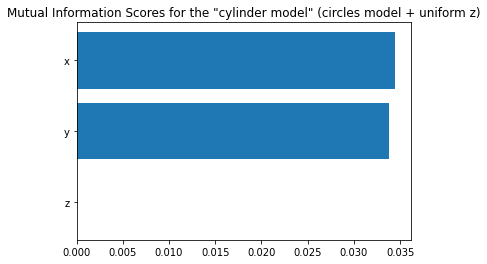

In [13]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y) #, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)

plot_mi_scores(make_mi_scores(circle_data[["x","y","z"]],circle_data["target"]))
plt.title("Mutual Information Scores for the \"cylinder model\" (circles model + uniform z)")

# 4) Example loss power in copper cable

Keep in mind : here I assess the performances on the same than the I trained on, which you should avoid !

As it was done for illustrative purposes it's more +/- fine

In [14]:
rand.seed(2442)

n_cables = 75000
current_density = 0.75 #A/mm^2

data_cable = pd.DataFrame()
data_cable['radius'] = rand.normal(13, 1.3, n_cables)
data_cable['length'] = rand.normal(3000, 3000*0.15, n_cables)
data_cable['resistivity'] = rand.normal(1.7*1e-5, 0.2*1.7*1e-5, n_cables)
data_cable = data_cable.assign(
    power=lambda x: np.pi * x.resistivity * x.length * (x.radius**2) * (current_density**2)
)

Text(0.5, 0, 'Puissance dissipee (en MW)')

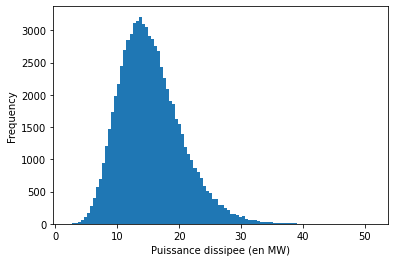

In [15]:
data_cable['power'].plot(kind='hist',bins=100)
plt.xlabel("Puissance dissipee (en MW)")

In [16]:
model = K.Sequential(
    [
        K.layers.Dense(6, activation="relu", name="layer1"),
        K.layers.Dense(6, activation="relu", name="layer2"),
        K.layers.Dense(6, activation="relu", name="layer3"),
        K.layers.Dense(6, activation="relu", name="layer4"),
        K.layers.Dense(1, name="layer5")
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(data_cable[["radius","length","resistivity"]], data_cable[["power"]], epochs=20, batch_size=1024)

Epoch 1/20


2022-02-22 10:20:25.115882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-02-22 10:20:25.115900: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-22 10:20:25.115923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-02-22 10:20:25.116063: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


74/74 [==============================] - 0s 901us/step - loss: 30808.4707 - mse: 30808.4707
Epoch 2/20
74/74 [==============================] - 0s 827us/step - loss: 508.0292 - mse: 508.0292
Epoch 3/20
74/74 [==============================] - 0s 833us/step - loss: 29.6054 - mse: 29.6054
Epoch 4/20
74/74 [==============================] - 0s 824us/step - loss: 19.3875 - mse: 19.3875
Epoch 5/20
74/74 [==============================] - 0s 820us/step - loss: 19.2948 - mse: 19.2948
Epoch 6/20
74/74 [==============================] - 0s 829us/step - loss: 19.2918 - mse: 19.2918
Epoch 7/20
74/74 [==============================] - 0s 816us/step - loss: 19.2908 - mse: 19.2908
Epoch 8/20
74/74 [==============================] - 0s 814us/step - loss: 19.2901 - mse: 19.2901
Epoch 9/20
74/74 [==============================] - 0s 828us/step - loss: 19.2867 - mse: 19.2867
Epoch 10/20
74/74 [==============================] - 0s 821us/step - loss: 19.2870 - mse: 19.2870
Epoch 11/20
74/74 [=============

In [17]:
res=model.predict(data_cable[["radius","length","resistivity"]])
res=res[:,0]-data_cable["power"]
res /= data_cable["power"]

9.429800275939614 34.60748107289961


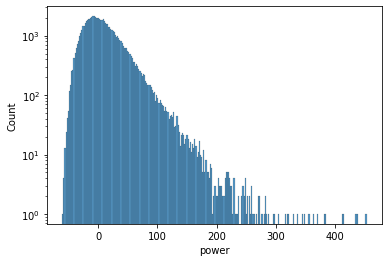

In [18]:
sns.histplot(100*res)
plt.yscale('log')
print(f"{np.mean(100*res)} {np.std(100*res)}")

In [19]:
model = K.Sequential(
    [
        K.layers.BatchNormalization(),
        K.layers.Dense(6, activation="relu", name="layer1"),
        K.layers.Dense(6, activation="relu", name="layer2"),
        K.layers.Dense(6, activation="relu", name="layer3"),
        K.layers.Dense(6, activation="relu", name="layer4"),
        K.layers.Dense(1, name="layer5")
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(data_cable[["radius","length","resistivity"]], data_cable[["power"]], epochs=20, batch_size=1024)

res2=model.predict(data_cable[["radius","length","resistivity"]])
res2=res2[:,0]-data_cable["power"]
res2 /= data_cable["power"]

Epoch 1/20
74/74 [==============================] - 1s 951us/step - loss: 253.2960 - mse: 253.2960
Epoch 2/20
74/74 [==============================] - 0s 927us/step - loss: 201.9177 - mse: 201.9177
Epoch 3/20
74/74 [==============================] - 0s 906us/step - loss: 75.2296 - mse: 75.2296
Epoch 4/20
74/74 [==============================] - 0s 920us/step - loss: 25.7081 - mse: 25.7081
Epoch 5/20
74/74 [==============================] - 0s 910us/step - loss: 14.0468 - mse: 14.0468
Epoch 6/20
74/74 [==============================] - 0s 906us/step - loss: 11.7988 - mse: 11.7988
Epoch 7/20
74/74 [==============================] - 0s 915us/step - loss: 11.0961 - mse: 11.0961
Epoch 8/20
74/74 [==============================] - 0s 927us/step - loss: 10.8125 - mse: 10.8125
Epoch 9/20
74/74 [==============================] - 0s 901us/step - loss: 10.6495 - mse: 10.6495
Epoch 10/20
74/74 [==============================] - 0s 927us/step - loss: 10.5353 - mse: 10.5353
Epoch 11/20
74/74 [======

4.828487924894068 24.92539441961382


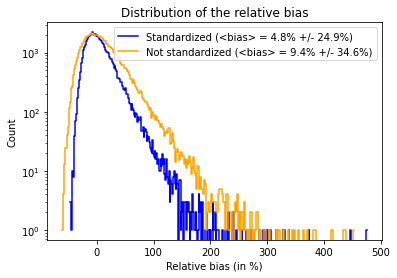

In [20]:
sns.histplot(100*res2,element='step',color='blue',label=f"Standardized (<bias> = {np.mean(100*res2):.1f}% +/- {np.std(100*res2):.1f}%)",fill=False)
sns.histplot(100*res,element='step',color='orange',label=f"Not standardized (<bias> = {np.mean(100*res):.1f}% +/- {np.std(100*res):.1f}%)",fill=False)
plt.yscale('log')
plt.legend()
plt.xlabel('Relative bias (in %)')
plt.title("Distribution of the relative bias")
print(f"{np.mean(100*res2)} {np.std(100*res2)}")

# 5) Example K-Means

In [21]:
rand.seed(2442)

true_nclus = rand.choice(range(4,8))
clus_range = range(true_nclus)

un=lambda: rand.uniform(-10,10)
gs=lambda x: rand.normal(x,2)

centroids = [np.array([un(), un()]) for i in clus_range]
covars = [np.diag([gs(1.5),gs(2)]) for i in clus_range]
npoints= [np.rint(np.abs(rand.normal(2500,2000))) for i in clus_range]

tmp = [
    pd.DataFrame(rand.multivariate_normal(centroids[i], covars[i], size=int(npoints[i])), columns=['x','y'])
    for i in range(true_nclus) 
]
for i in range(len(tmp)): 
    tmp[i]['true_cluster'] = i

data_clustering = pd.concat(tmp)

/tmp/ipykernel_354/3203182361.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  pd.DataFrame(rand.multivariate_normal(centroids[i], covars[i], size=int(npoints[i])), columns=['x','y'])


Text(0.5, 1.0, 'Distribution of generated data, colored by the cluster they truly belong to')

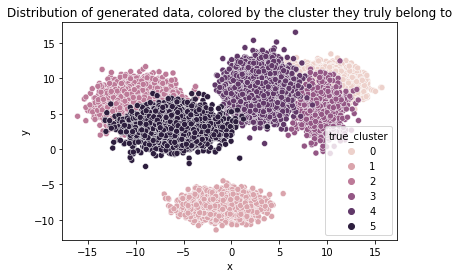

In [22]:
sns.scatterplot(data=data_clustering, x='x', y='y', hue='true_cluster')
plt.title('Distribution of generated data, colored by the cluster they truly belong to')

Text(0.5, 1.0, 'Distribution of generated data, colored by the clusters KMeans (N=6) attach them to')

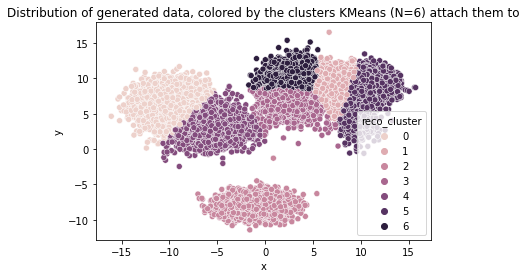

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=2442).fit(data_clustering[ ['x','y'] ])
data_clustering['reco_cluster'] = kmeans.predict(data_clustering[ ['x','y'] ])

sns.scatterplot(data=data_clustering, x='x', y='y', hue='reco_cluster')
plt.title('Distribution of generated data, colored by the clusters KMeans (N=6) attach them to')

# 6) Example Principal Compenent Analysis

In [24]:
from sklearn.decomposition import PCA
rand.seed(2442)

In [25]:
tmp = rand.rand(25,25)
cov = np.dot(tmp, tmp.transpose())
means = rand.uniform(-2,2,25)
data_pca = pd.DataFrame(rand.multivariate_normal(means, cov, size=1000000))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

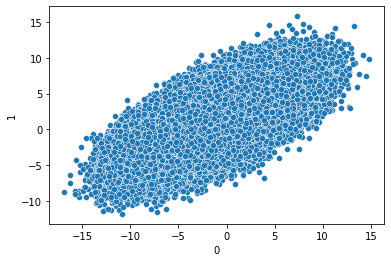

In [26]:
sns.scatterplot(data_pca[0],data_pca[1])

In [27]:
pca = PCA().fit(data_pca)

<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>

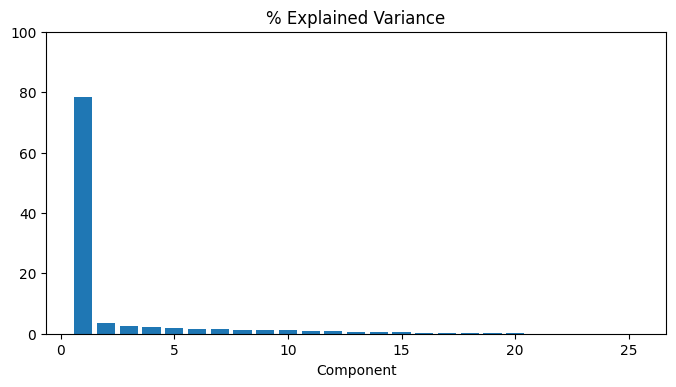

In [28]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 1)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = 100*pca.explained_variance_ratio_
    axs.bar(grid, evr)
    axs.set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 100.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca)

# 7) Example training history

In [29]:
rand.seed(2442)

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split 

In [30]:
train_X, test_X, train_y, test_y = train_test_split(data_cable[["radius","length","resistivity"]],data_cable["power"])
eval_set = [(train_X, train_y), (test_X, test_y)]

xreg=XGBRegressor(n_estimators=1000)
xreg.fit(train_X,train_y, eval_set=eval_set, eval_metric=["rmse"], verbose=False)

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
from sklearn.metrics import mean_squared_error
mean_squared_error(xreg.predict(test_X),test_y)

0.04282006445467768

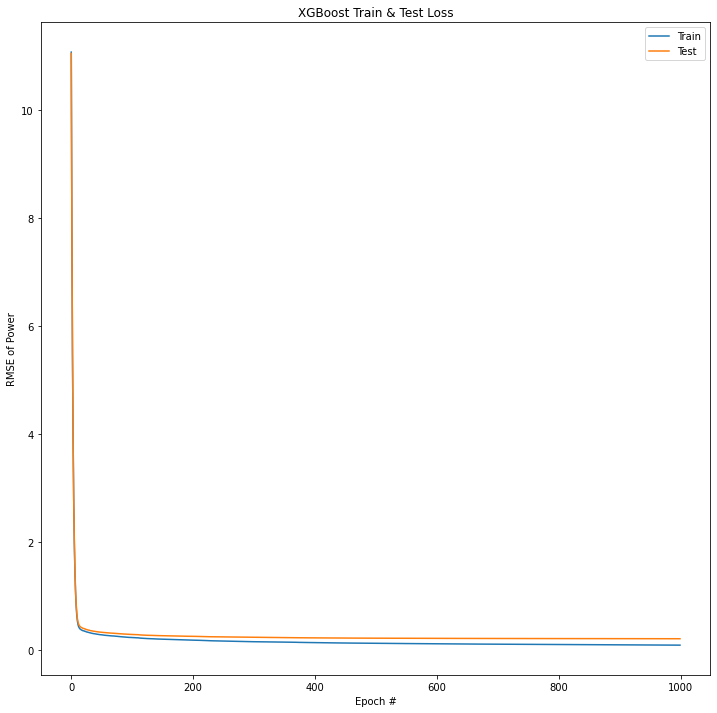

In [32]:
results = xreg.evals_result()
epochs = len(results["validation_0"]["rmse"])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["rmse"], label="Train")
ax.plot(x_axis, results["validation_1"]["rmse"], label="Test")
ax.legend()
plt.ylabel("RMSE of Power")
plt.xlabel("Epoch #")
plt.title("XGBoost Train & Test Loss")
plt.show()

# 8) Example Missing values

In [33]:
! wget https://github.com/njtierney/melb-housing-data/raw/master/data-raw/melbourne_housing_raw.csv

--2022-02-22 10:21:06--  https://github.com/njtierney/melb-housing-data/raw/master/data-raw/melbourne_housing_raw.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/njtierney/melb-housing-data/master/data-raw/melbourne_housing_raw.csv [following]
--2022-02-22 10:21:07--  https://raw.githubusercontent.com/njtierney/melb-housing-data/master/data-raw/melbourne_housing_raw.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4416652 (4.2M) [text/plain]
Saving to: ‘melbourne_housing_raw.csv.3’

melbourne_housing_r 100%[===================>]   4.21M  3.70MB/s    in 1.1s    

2022-02-22 10:21:08 (3.70 

In [34]:
melbourne_housing = pd.read_csv('melbourne_housing_raw.csv')
print(melbourne_housing[["Suburb","Price","SellerG","YearBuilt"]].head())
print('\n#\n#\n#\n')
print(melbourne_housing.isna().sum())
print(len(melbourne_housing))

       Suburb      Price SellerG  YearBuilt
0  Abbotsford        NaN  Jellis        NaN
1  Abbotsford  1480000.0  Biggin        NaN
2  Abbotsford  1035000.0  Biggin     1900.0
3  Abbotsford        NaN  Rounds        NaN
4  Abbotsford  1465000.0  Biggin     1900.0

#
#
#

Suburb               0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64
34857


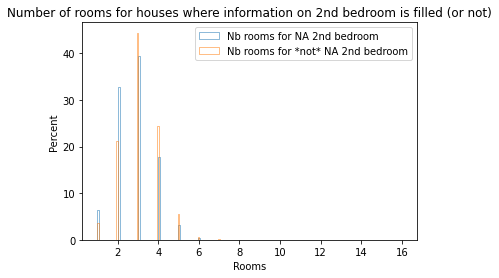

In [35]:
sns.histplot(melbourne_housing[melbourne_housing.Bedroom2.isna()],x="Rooms",fill=False,stat='percent',label="Nb rooms for NA 2nd bedroom")
sns.histplot(melbourne_housing[~melbourne_housing.Bedroom2.isna()],x="Rooms",fill=False,stat='percent',label="Nb rooms for *not* NA 2nd bedroom")
plt.title("Number of rooms for houses where information on 2nd bedroom is filled (or not)")
plt.legend()
plt.show()

In [36]:
len(melbourne_housing)

34857

In [37]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)
imputer.feature_names_in_ = ['Lattitude','Longtitude']
imputed = imputer.fit_transform(melbourne_housing[['Lattitude','Longtitude','Price']])

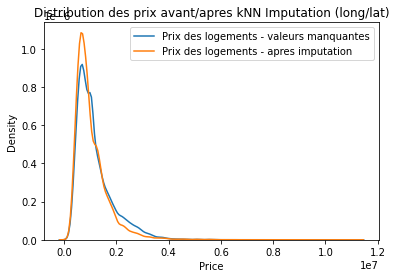

In [38]:
sns.kdeplot(x=imputed[:,2],fill=False,label="Prix des logements - valeurs manquantes")
sns.kdeplot(x=melbourne_housing["Price"],fill=False,label="Prix des logements - apres imputation")
plt.legend()
plt.title("Distribution des prix avant/apres kNN Imputation (long/lat)")
plt.show()

# 9) Geographic things

In [39]:
! rm 0e117c06-248f-45e5-8945-0e79d9136165
! wget -nv https://www.data.gouv.fr/fr/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165
! unzip -u 0e117c06-248f-45e5-8945-0e79d9136165

! rm base-cc-evol-struct-pop-2013.zip
! wget -nv https://www.insee.fr/fr/statistiques/fichier/2044751/base-cc-evol-struct-pop-2013.zip
! unzip -u base-cc-evol-struct-pop-2013.zip

2022-02-22 10:22:29 URL:https://osm13.openstreetmap.fr/~cquest/openfla/export/communes-20220101-shp.zip [228507601/228507601] -> "0e117c06-248f-45e5-8945-0e79d9136165" [1]
Archive:  0e117c06-248f-45e5-8945-0e79d9136165
2022-02-22 10:23:28 URL:https://www.insee.fr/fr/statistiques/fichier/2044751/base-cc-evol-struct-pop-2013.zip [42641330] -> "base-cc-evol-struct-pop-2013.zip" [1]
Archive:  base-cc-evol-struct-pop-2013.zip


In [2]:
fr_map = gpd.read_file("communes-20220101.shp")
fr_map.set_index('insee',inplace=True)

fr_recensement=pd.read_excel('base-cc-evol-struct-pop-2013.xls',sheet_name='COM_2013',skiprows=5,index_col='CODGEO')
map_recens = gpd.GeoDataFrame(pd.concat([fr_map,fr_recensement],axis=1))
map_recens = map_recens[ (~map_recens.index.str.startswith('97')) & (map_recens['P13_POP']>200) ]

In [3]:
avage = {'0014':7,'1529':22,'3044':37,'4559':52,'6074':67,'7589':82,'90P':95}
    
def revenues(x,d):
    res = 0
    for k,v in d.items():
        tmp=5*v*x[f"P13_POP{k}"]
        res += rand.normal(10*tmp,tmp)
    return res

map_recens = map_recens.assign(revenues=lambda x: revenues(x,avage))

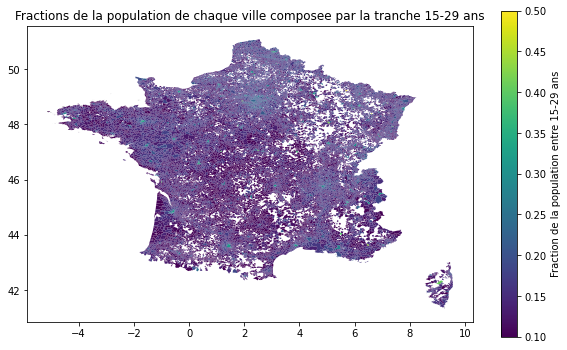

In [46]:
map_recens.plot(
    column='frac_POP1529',figsize=(10,6),edgecolor='none',legend=True,
    #norm=matplotlib.colors.LogNorm(vmin=10, vmax=map_recens.P13_POP1529.max()),
    vmin=0.1, vmax=0.5,
    legend_kwds={'label': "Fraction de la population entre 15-29 ans"}
)
plt.title("Fractions de la population de chaque ville composee par la tranche 15-29 ans")
plt.show()

# 10) Series temporelles
### 1- Generating AR model

In [113]:
rand.seed(2442)
from statsmodels.tsa.arima_process import ArmaProcess
ar = np.array([1,0.7,-0.2])
ma = np.array([1])
AR_simu = ArmaProcess(ar,ma)
simu_data = AR_simu.generate_sample(nsample=50)

Text(0, 0.5, 'y')

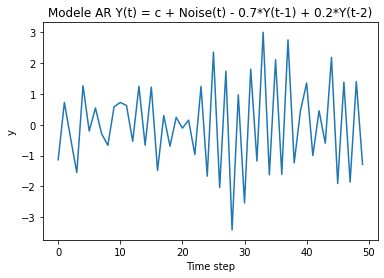

In [114]:
plt.plot(simu_data)
plt.title("Modele AR Y(t) = c + Noise(t) - 0.7*Y(t-1) + 0.2*Y(t-2)")
plt.xlabel('Time step')
plt.ylabel('y')

Text(0.5, 1.0, 'Auto-correlation for an AR(2) model')

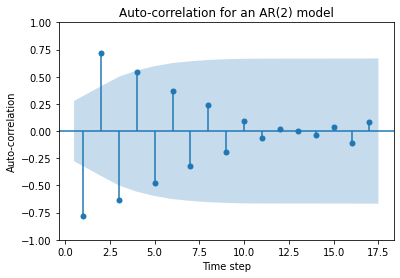

In [115]:
plot_acf(simu_data,zero=False)
plt.xlabel('Time step')
plt.ylabel('Auto-correlation')
plt.title('Auto-correlation for an AR(2) model')

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'Partial auto-correlation for an AR(2) model')

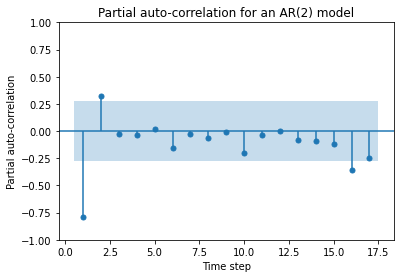

In [116]:
plot_pacf(simu_data,zero=False)
plt.xlabel('Time step')
plt.ylabel('Partial auto-correlation')
plt.title('Partial auto-correlation for an AR(2) model')

### 2- Generating MA model

In [137]:
rand.seed(2442)

ar = np.array([1])
ma = np.array([1,0.5,0.9])
AR_simu = ArmaProcess(ar,ma)
simu_data = AR_simu.generate_sample(nsample=75)

Text(0, 0.5, 'y')

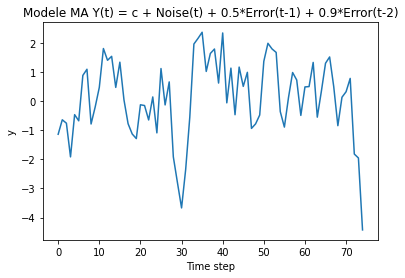

In [138]:
plt.plot(simu_data)
plt.title("Modele MA Y(t) = c + Noise(t) + 0.5*Error(t-1) + 0.9*Error(t-2)")
plt.xlabel('Time step')
plt.ylabel('y')

Text(0.5, 1.0, 'Auto-correlation for a MA(2) model')

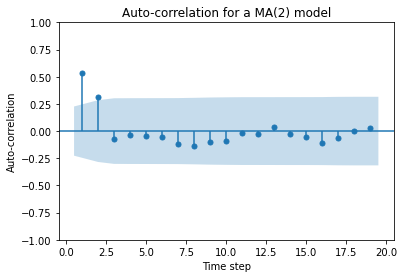

In [139]:
plot_acf(simu_data,zero=False)
plt.xlabel('Time step')
plt.ylabel('Auto-correlation')
plt.title('Auto-correlation for a MA(2) model')

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'Partial auto-correlation for a MA(2) model')

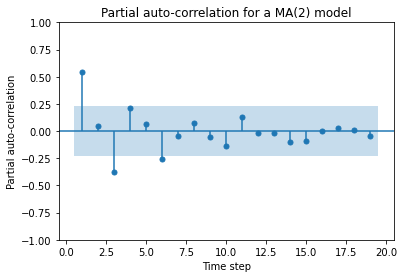

In [140]:
plot_pacf(simu_data,zero=False)
plt.xlabel('Time step')
plt.ylabel('Partial auto-correlation')
plt.title('Partial auto-correlation for a MA(2) model')

### 3- CO2 with xgBoost

<AxesSubplot:>

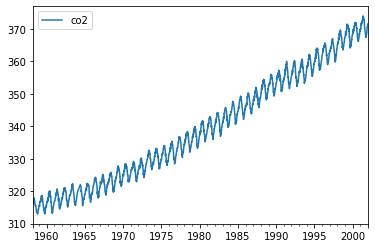

In [144]:
import statsmodels.datasets.co2 as co2
co2_data = co2.load_pandas().data
co2_data = co2_data.fillna(co2_data.interpolate())

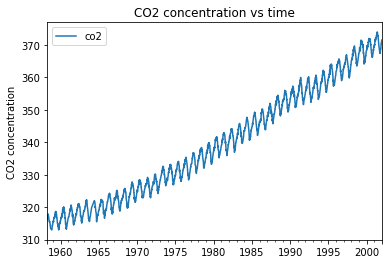

In [145]:
co2_data.plot(y='co2')
plt.ylabel('CO2 concentration')
plt.title('CO2 concentration vs time')
plt.show()

In [148]:
len(co2_data)

2284

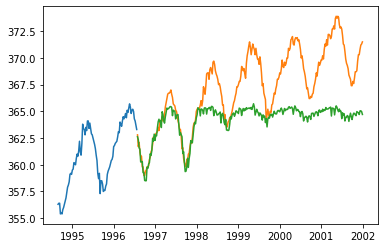

In [163]:
# extract the seasonality data
months = [x.month for x in co2_data.index]
years = [x.year for x in co2_data.index]
day = [x.day for x in co2_data.index]
lag1 = co2_data['co2'].shift(1).values
lag2 = co2_data['co2'].shift(2).values
 
# convert into one matrix
X = np.array([day, months, years, lag1, lag2]).T


X_train, X_test = X[0:2000], X[2000:]
y_train, y_test = co2_data.co2.values[0:2000], co2_data.co2.values[2000:]

my_xgb = xg.XGBRegressor()
my_xgb.fit(X_train, y_train)


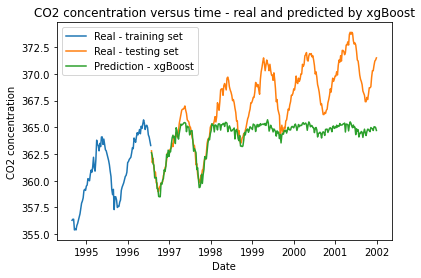

In [167]:

preds = my_xgb.predict(X_test)
plt.plot(co2_data.index[1900:2000], y_train[1900:2000], label='Real - training set')
plt.plot(co2_data.index[2000:], y_test, label='Real - testing set')
plt.plot(co2_data.index[2000:], preds, label='Prediction - xgBoost')
plt.title("CO2 concentration versus time - real and predicted by xgBoost")
plt.xlabel("Date")
plt.ylabel("CO2 concentration")
plt.legend()

# 11) Random Forests

In [179]:
! wget https://github.com/npradaschnor/Pima-Indians-Diabetes-Dataset/raw/master/diabetes.csv

--2022-02-23 15:52:49--  https://github.com/npradaschnor/Pima-Indians-Diabetes-Dataset/raw/master/diabetes.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv [following]
--2022-02-23 15:52:50--  https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23105 (23K) [text/plain]
Saving to: ‘diabetes.csv.1’

diabetes.csv.1      100%[===================>]  22.56K  --.-KB/s    in 0.006s  

2022-02-23 15:52:50 (3.88 MB/s) - ‘diabetes.csv.1’ saved [23105

In [193]:
data_diabetes = pd.read_csv('diabetes.csv')
len(data_diabetes)

768

In [195]:
from sklearn.model_selection import train_test_split
features=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']
targ='Outcome'

X_train, X_test, y_train, y_test = train_test_split(data_diabetes[features], data_diabetes[targ], test_size=0.35)

In [196]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

RandomForestClassifier()

In [197]:
preds = rf.predict(X_test)

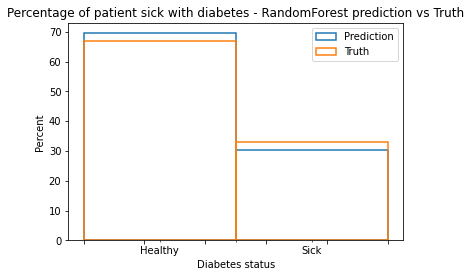

In [209]:
ax = sns.histplot(preds,stat='percent',bins=2,fill=False,label='Prediction')
sns.histplot(y_test,stat='percent',bins=2,fill=False,label='Truth',ax = ax)
plt.xlabel('Diabetes status')
plt.legend()
ax.set_xticklabels('')
ax.set_xticks([0,.25,0.5,0.75,1],minor=True)
ax.set_xticklabels(['','Healthy','','Sick',''],minor=True)
plt.title('Percentage of patient sick with diabetes - RandomForest prediction vs Truth')
plt.show()